## EDA on data performance


In [ ]:
import pandas as pd
import os
from os import path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
import random
from tqdm import tqdm
import math

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
# tf.enable_eager_execution()
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

## EDA on input data

In [ ]:
import pandas as pd
import os
from os import path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
import random
from tqdm import tqdm
import math

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
# tf.enable_eager_execution()
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

In [ ]:
#importing pre_trained model
import segmentation_models as sm
from segmentation_models.metrics import iou_score
focal_loss = sm.losses.cce_dice_loss

trained_model = tf.keras.models.load_model('C:/Users/redga/Desktop/unet_2mil', {'iou_score':iou_score, 'categorical_crossentropy_plus_dice_loss':focal_loss})

Segmentation Models: using `tf.keras` framework.


In [ ]:
#Function to calculate IoU scores 
def data_evaluvation(path):
    iou_scores=[]
    for i in tqdm(range(len(path))):
        rgb = cv2.imread(path['cropped_images'][i])
        #normalizing the image
        rgb = rgb/255
        actual_mask = cv2.imread(path['cropped_masks'][i])
        actual_mask = actual_mask[:,:,0]
        #creating seperate mask for each class and stackinh them to create a mask
        actual_mask = [(actual_mask == v) for v in [255,0]]
        actual_mask = np.stack(actual_mask, axis=-1).astype('float')
        pred_mask = trained_model.predict(rgb[np.newaxis,:,:,:])
        iou_scores.append(iou_score(actual_mask, pred_mask))
        
    return(iou_scores)

In [ ]:
#Calculating IoU scores for input data
cropped['iou_scores'] = data_evaluvation(cropped[:])

In [ ]:
#Storing the dataframe with IoU scores
cropped.to_csv(r'C:/Users/redga/Desktop/cropped_iou.csv', index=False)

In [ ]:
#reading the dataframe with IoU scores
cropped_iou = pd.read_csv(r'C:/Users/redga/Desktop/cropped_iou.csv')

(array([  16.,  227.,  797.,  300.,  450.,  748., 1309., 1839., 1659.,
         314.]),
 array([0.38867683, 0.44314535, 0.49761386, 0.55208238, 0.60655089,
        0.6610194 , 0.71548792, 0.76995643, 0.82442494, 0.87889346,
        0.93336197]),
 <BarContainer object of 10 artists>)

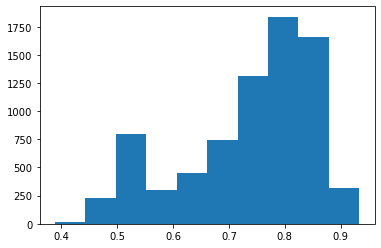

In [ ]:
plt.hist(cropped_iou['iou_scores'])

In [ ]:
#Splitting the data three dataframes using IoU scores to better evaluvate the data and model

def split(path, threshold):
    below_average = pd.DataFrame(columns=['cropped_images', 'cropped_masks', 'iou_scores'])
    average = pd.DataFrame(columns=['cropped_images', 'cropped_masks', 'iou_scores'])
    best = pd.DataFrame(columns=['cropped_images', 'cropped_masks', 'iou_scores'])
    for i in range(len(path)):
        if path['iou_scores'][i]<=threshold[0]:
            below_average = below_average.append(path.iloc[i], ignore_index = True)
            
        elif path['iou_scores'][i]<=threshold[1]:
            average = average.append(path.iloc[i], ignore_index = True)
        
        else:
            best = best.append(path.iloc[i], ignore_index = True)
            
    return(below_average, average, best)

In [ ]:
below_average, average, best = split(cropped_iou, [0.6,0.8])

In [ ]:
#Function to plot 20 random original images, masks and predicted masks
def plot(df):
    for i in range(20):
      rand = random.randint(0,len(df)) 
      image = cv2.imread(df['cropped_images'][rand])
      mask = cv2.imread(df['cropped_masks'][rand])
      pred = trained_model.predict(image[np.newaxis,:,:,:]/255)
      plt.figure(figsize=(20,25))
      plt.subplot(131)
      plt.title(df['cropped_images'][rand].split('/')[-1] + '  row: '+ str(rand))
      plt.imshow(image)
      plt.subplot(132)
      plt.title(df['cropped_masks'][rand].split('/')[-1])
      plt.imshow(mask[:,:,0])
      plt.subplot(133)
      plt.title(df['iou_scores'][rand])
      plt.imshow(pred[0,:,:,0])

In [ ]:
def plot_given(df, row):
    for i in row:
      image = cv2.imread(df['cropped_images'][i])
      mask = cv2.imread(df['cropped_masks'][i])
      pred = trained_model.predict(image[np.newaxis,:,:,:]/255)
      plt.figure(figsize=(20,25))
      plt.subplot(131)
      plt.title('original_image')
      plt.imshow(image)
      plt.subplot(132)
      plt.title('original_mask')
      plt.imshow(mask[:,:,0])
      plt.subplot(133)
      plt.title('predicted_mask - IoU score: '+ str(df['iou_scores'][i]) )
      plt.imshow(pred[0,:,:,0])

### plotting images and masks which produces the worst results

In [ ]:
#plotting images, masks and predicted masks with iou_score less than 0.6
plot(below_average)

### Observations of data the produces below average results

In [ ]:
rand = 943
image = cv2.imread(below_average['cropped_images'][rand])
mask = cv2.imread(below_average['cropped_masks'][rand])
pred = trained_model.predict(image[np.newaxis,:,:,:]/255)
plt.figure(figsize=(20,25))
plt.subplot(131)
plt.title(df['cropped_images'][rand].split('/')[-1] + '  row: '+ str(rand))
plt.imshow(image)
plt.subplot(132)
plt.title(df['cropped_masks'][rand].split('/')[-1])
plt.imshow(mask[:,:,0])
plt.subplot(133)
plt.title(df['iou_scores'][rand])
plt.imshow(pred[0,:,:,0])

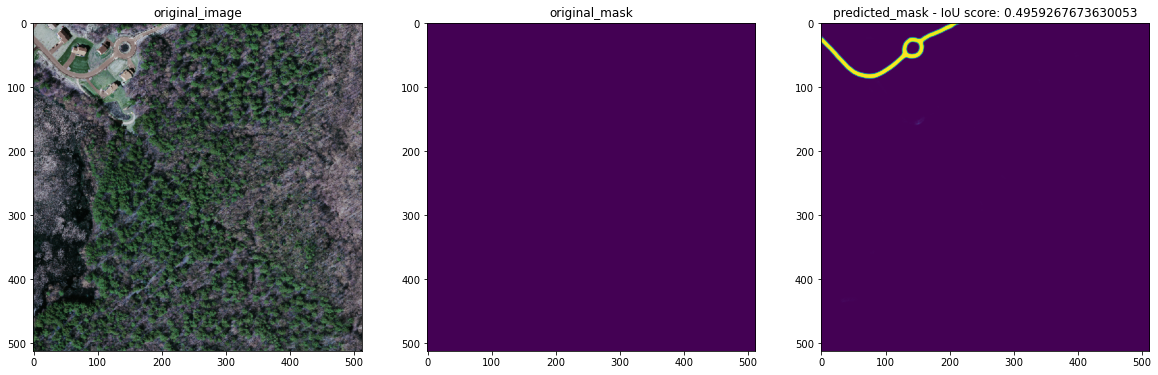

In [ ]:
plot_given(below_average, [943])

In the above image model segments the road from the origianl image but the original mask does not contain the road there are multiple cases of this senario

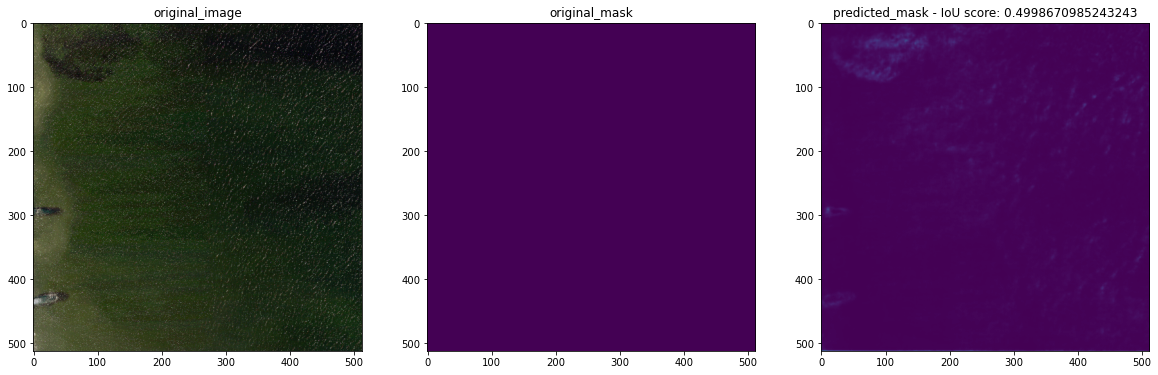

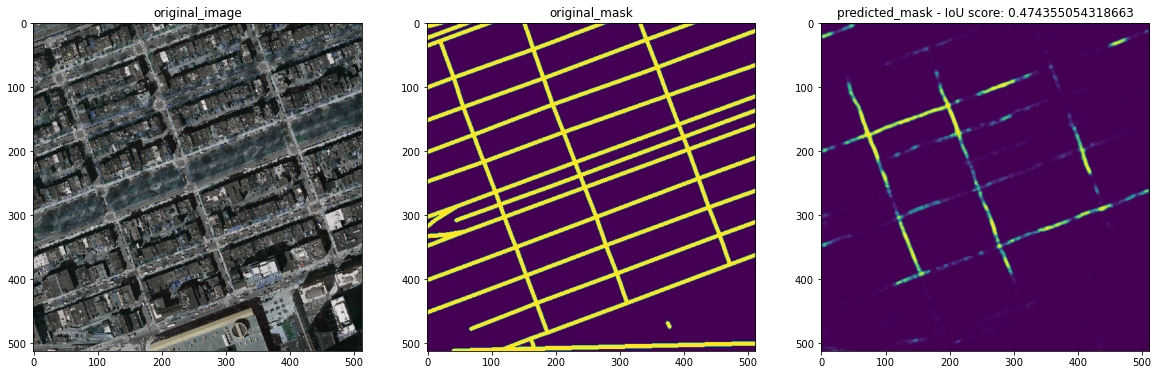

In [ ]:
plot_given(below_average, [981])
plot_given(below_average, [718])

model struggles to segment images with no roads and narrow streets roads with lot of buildings in the secong image you can see that the roads not masked properly in the original masks leading to models poor performance

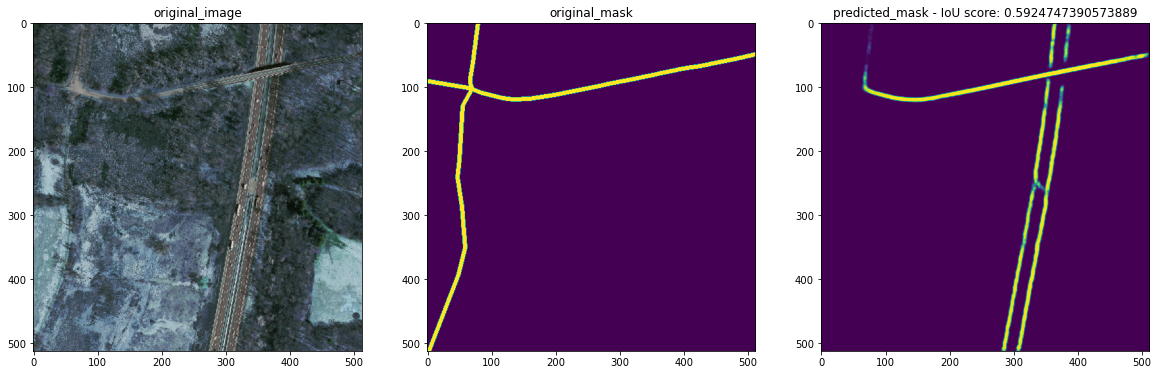

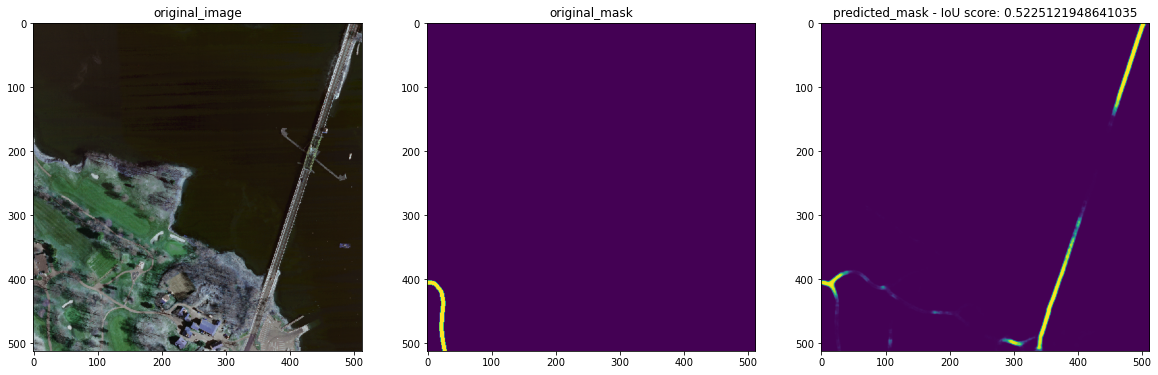

In [ ]:
plot_given(below_average, [63])
plot_given(below_average, [1071])

In many images some roads just straightup leftout of the original masks or incorrectly marked

### Observations of data that produces average results


In [ ]:
#plotting images, masks and predicted masks with iou_score greater than 0.6 and less than 0.8
plot(average)

### Observations

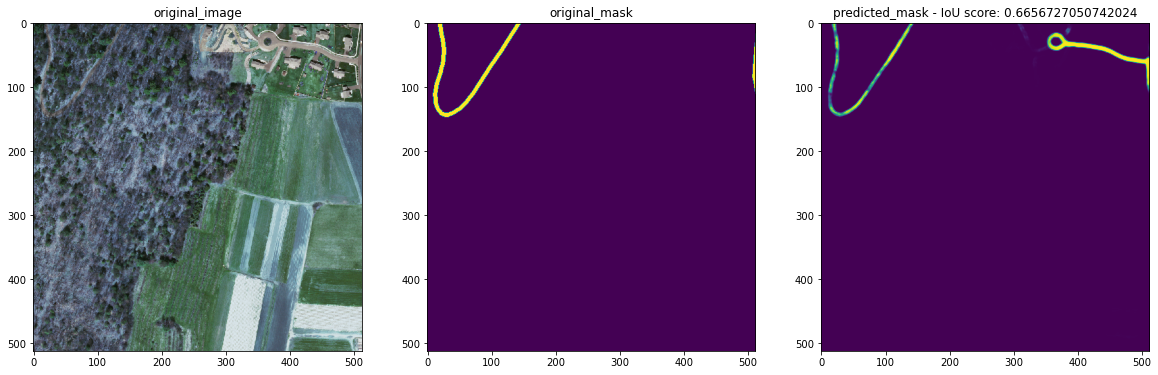

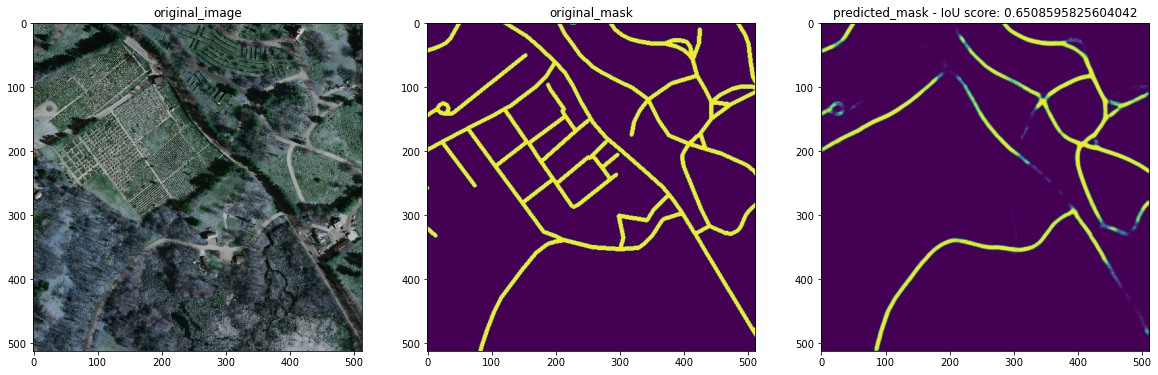

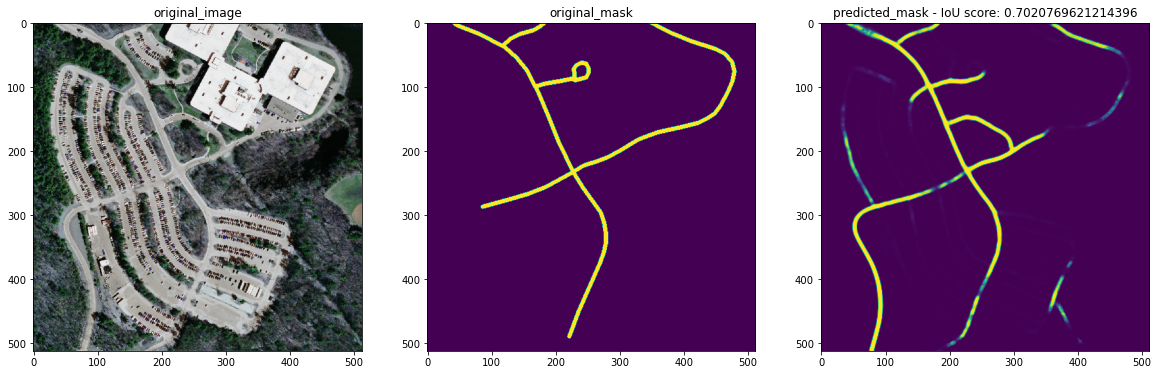

In [ ]:
plot_given(average, [7])
plot_given(average, [1751])
plot_given(average, [1071])

There are multiple case of incorrect segmentation of original masks and model struggles to segment roads on lush areas where road are not clearly visble from the top due to trees

### Observations of data that produces above average results

In [ ]:
#plotting images, masks and predicted masks with iou_score greater than 0.8
plot(best)

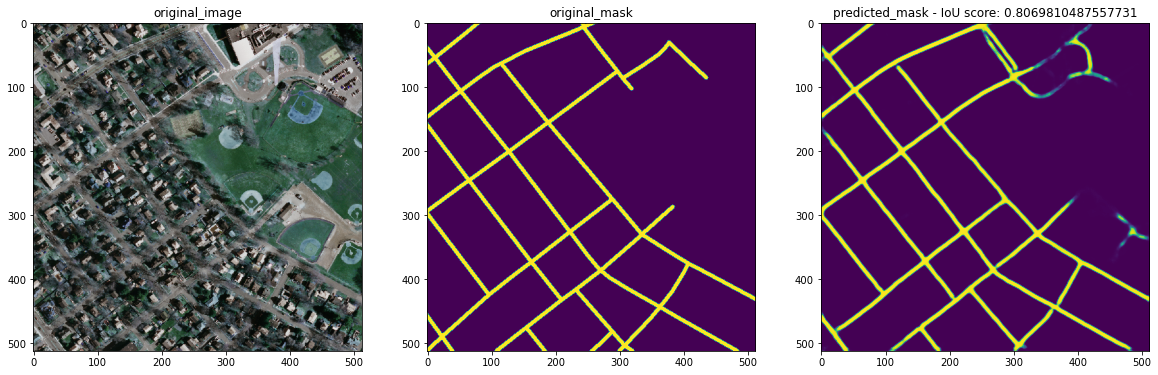

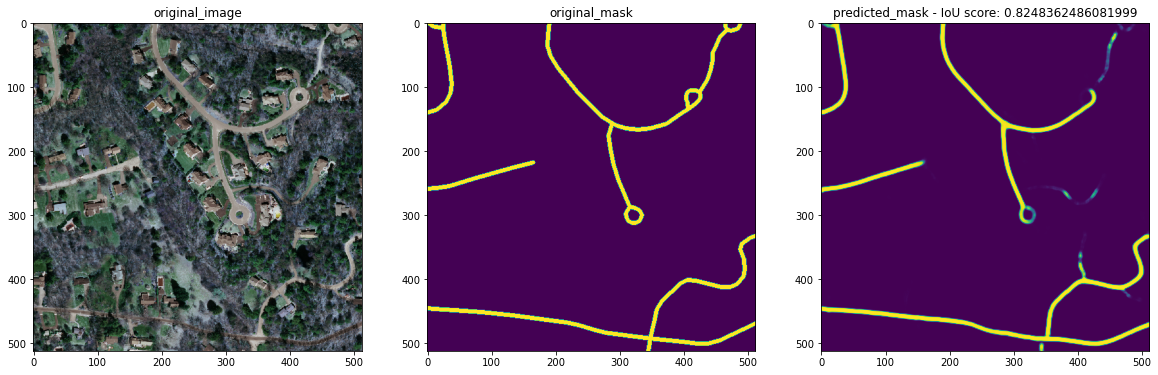

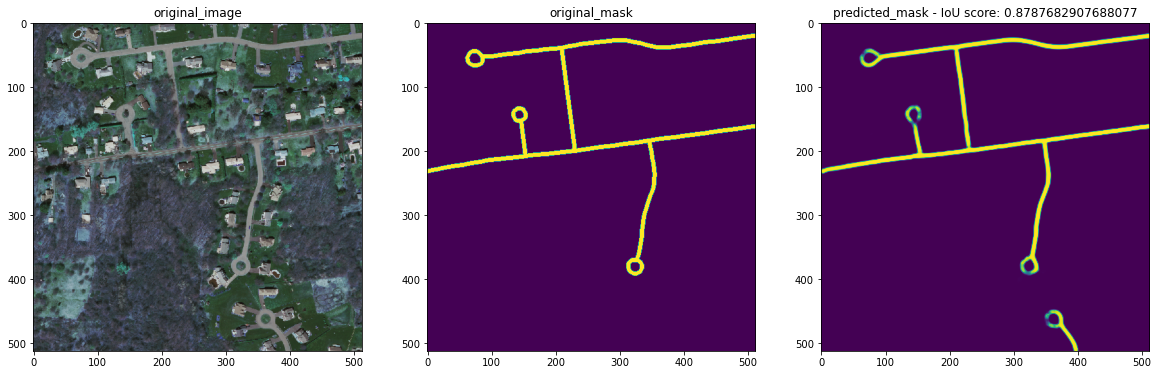

In [ ]:
plot_given(best, [2386])
plot_given(best, [1408])
plot_given(best, [205])

There are some discrepancies between original image and original mask (some roads are not segmented or segmented incorrectly) but model preforms respectabily. Models performance can be improved by getting data with accurate masks.

### Conclusion


1.   Model's performance is greatly affected by quality of the data
2.   Most images with low IoU scores have incomplete original masks (roads are present in ariel image but not on mask), which leads to low IoU scores
3.   Images with average and above average IoU scores also suffer from incomplete original masks although not as severe as images with low IoU scores
4.   Model struggles to segment out narrow street roads with buildings and dense forest area with unpaved roads.

